In [61]:
api_token = {"username":"kenwu69","key":"b8e96dc22de433bebb56f2ebc0855670"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d alxmamaev/flowers-recognition --force
 
!ls /kaggle

 99% 222M/225M [00:01<00:00, 204MB/s]
100% 225M/225M [00:01<00:00, 199MB/s]
flowers  flowers-recognition.zip  save_bad.pt


In [62]:
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/

---

In [ ]:
import cv2 
import numpy as np
import torch
import pandas as pd
from pathlib import Path
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.models as model
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from matplotlib import pyplot as plt
from skimage.transform import resize

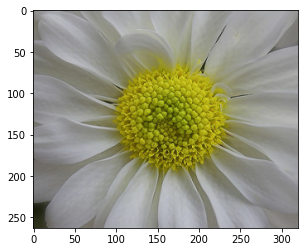

In [ ]:
img = cv2.imread("flowers/daisy/100080576_f52e8ee070_n.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
data_path = "flowers"

In [ ]:
def preprocessing_img(in_path):
    img_flat = []
    img_list = []
    img_label = []
    cat = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    for i in cat:
        # print(i)
        path = os.path.join(in_path, i)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img))
            try:
                img_arr.shape
                # print("checked for shape".format(img_arr.shape))
            except AttributeError:
                print("shape not found")
                continue
            #code to move to next frame
            # plt.imshow(img_arr)
            # plt.show()
            img_arr = resize(img_arr,(80,60,3))
            img_flat.append(img_arr.flatten())
            img_list.append(img_arr)
            img_label.append(i)
    return np.array(img_flat), np.array(img_list), np.array(img_label)

data_img_flat, data_img_list, data_img_label = preprocessing_img(data_path)

In [ ]:
df = pd.DataFrame(data_img_flat)
df['label'] = data_img_label
print(df.shape)

(4317, 14401)


In [ ]:
labels = df['label'].value_counts().index.tolist()
labels

['dandelion', 'tulip', 'rose', 'daisy', 'sunflower']

---

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from prettytable import PrettyTable

In [ ]:
df_train_val, df_test = train_test_split(df, test_size = 0.3, random_state=23)
print(df_train_val.shape)
print(df_test.shape)

(3021, 14401)
(1296, 14401)


---
HOG

In [ ]:
from skimage.feature import hog
from skimage import data, color, feature

In [ ]:
data_img_list.shape

(4317, 80, 60, 3)

In [ ]:
ppc = 8
hog_images = []
hog_features = []

for image in data_img_list:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)                                    

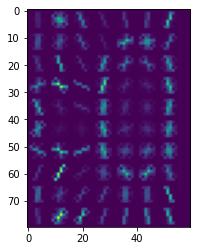

In [ ]:
plt.imshow(hog_images[56])

In [ ]:
hog_features = np.array(hog_features)
print(hog_features.shape)

(4317, 3584)


In [ ]:
df = pd.DataFrame(hog_features)
df['label'] = data_img_label
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3575,3576,3577,3578,3579,3580,3581,3582,3583,label
0,0.062541,0.088135,0.173713,0.029315,0.109577,0.025727,0.024124,0.030472,0.026425,0.016801,...,0.015296,0.046480,0.000000,0.000315,0.000000,0.002784,0.000557,0.002439,0.025107,daisy
1,0.400121,0.025135,0.020263,0.014152,0.024556,0.000000,0.000837,0.045809,0.074025,0.125348,...,0.025614,0.116186,0.038288,0.032487,0.013701,0.041836,0.054857,0.164775,0.111156,daisy
2,0.007994,0.017455,0.006424,0.001106,0.008459,0.000332,0.000573,0.000000,0.002326,0.002153,...,0.037414,0.114556,0.019000,0.014845,0.036171,0.046031,0.036935,0.064479,0.118256,daisy
3,0.039815,0.033069,0.100199,0.027838,0.047394,0.010115,0.000000,0.011004,0.085699,0.025885,...,0.024604,0.035699,0.020679,0.036297,0.126031,0.253550,0.036396,0.000000,0.000000,daisy
4,0.042416,0.400206,0.020999,0.000000,0.010762,0.007335,0.000000,0.000000,0.043483,0.052889,...,0.053626,0.009432,0.015775,0.022201,0.009895,0.010764,0.002987,0.003471,0.007452,daisy


In [ ]:
df_train_val, df_test = train_test_split(df, test_size = 0.3, random_state=23)
print(df_train_val.shape)
print(df_test.shape)

(3021, 3585)
(1296, 3585)


In [ ]:
X_train_val = df_train_val.drop(['label'], axis = 1)
y_train_val = df_train_val['label']
X_test = df_test.drop(['label'], axis = 1)
y_test = df_test['label']

In [ ]:
K = 5
kf = KFold(n_splits = K)
svc = SVC(kernel='linear')
acc_sum = 0
pre_sum = 0
rec_sum = 0


for train_index, val_index in kf.split(X_train_val):
    print("PASS")
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)
    acc_sum += accuracy_score(y_val, y_pred)
    pre_sum += precision_score(y_val, y_pred, average = None)
    rec_sum += recall_score(y_val, y_pred, average = None)

acc_avg = acc_sum / K
pre_avg = pre_sum / K
rec_avg = rec_sum / K

print("##### Validation ##########################################################")
print("##### {}-Fold ##############################################################".format(K))
print("##### SVC #################################################################")
print("##### kernel = linear #####################################################")
myTable = PrettyTable()
myTable.add_column("Class", labels)
myTable.add_column("Accuracy", [acc_avg, acc_avg, acc_avg, acc_avg, acc_avg])
myTable.add_column("Precision", pre_avg)
myTable.add_column("Recall", rec_avg)
print(myTable)
# print(pd.DataFrame(cm_avg))
print("##### Test ################################################################")
y_pred = svc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
myTable = PrettyTable()
myTable.add_column("Class", labels)
myTable.add_column("Accuracy", [acc, acc, acc, acc, acc])
myTable.add_column("Precision", precision_score(y_test, y_pred, average=None))
myTable.add_column("Recall", recall_score(y_test, y_pred, average=None))
print(myTable)
# print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


PASS
PASS
PASS
PASS
PASS
##### Validation ##########################################################
##### 5-Fold ##############################################################
##### SVC #################################################################
##### kernel = linear #####################################################
+-----------+---------------------+---------------------+---------------------+
|   Class   |       Accuracy      |      Precision      |        Recall       |
+-----------+---------------------+---------------------+---------------------+
| dandelion | 0.37536150183350664 |  0.3104356141675953 | 0.36113209219196396 |
|   tulip   | 0.37536150183350664 |  0.3935359889353511 | 0.41905989408602684 |
|    rose   | 0.37536150183350664 |  0.3556999952214491 |  0.3543775429872494 |
|   daisy   | 0.37536150183350664 |  0.3603975232854104 |  0.3204991215878981 |
| sunflower | 0.37536150183350664 | 0.45834982978310784 | 0.40106212006128195 |
+-----------+------------------